In [37]:
import shutil
import os

os.makedirs("/kaggle/working/data", exist_ok = True)

src_folder = "/kaggle/input/ml-btl1-data/data"
dst_folder = "/kaggle/working/data"

if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)

# Copy the folder
shutil.copytree(src_folder, dst_folder)
print("Folder copied successfully!")

Folder copied successfully!


In [38]:
# !conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

# Library

In [39]:
# file train_set.py nằm trong models/trained/
import numpy as np
import pandas as pd
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [40]:
# Loading the preprocess data
train = np.load("./data/preprocessed/train_data.npz") 
test = np.load("./data/preprocessed/test_data.npz")

In [41]:
# Get the data for training and testing
X_train = torch.tensor(train["x_train"], dtype=torch.float32)
y_train = torch.tensor(train['y_train'], dtype=torch.long)
X_test = torch.tensor(test["x_test"], dtype=torch.float32)
y_test = torch.tensor(test['y_test'], dtype=torch.long)

In [42]:
print(X_train[:1])
print(y_train[:1])
print()

tensor([[ 7.4399e-02, -1.1589e-02, -6.3854e-04,  1.9306e-03, -1.5033e-03,
          1.7538e-03, -6.7158e-04,  2.1965e-03, -2.8524e-04, -1.4118e-03,
         -6.3664e-04,  1.1035e-03, -5.6107e-04,  1.5204e-04, -1.0995e-03,
          3.6707e-04,  4.2912e-04, -2.5798e-04,  1.9806e-04,  3.5367e-05,
          7.9351e-04,  2.1211e-04, -5.7816e-04, -5.2293e-04,  9.2334e-04,
         -3.0479e-04, -1.3429e-04, -3.1683e-04,  5.4127e-04,  1.4506e-03,
         -4.0189e-04,  3.3506e-04,  4.6412e-04, -1.5113e-04,  4.9940e-04,
          4.5944e-04, -6.5361e-04, -2.2310e-04,  1.9556e-04,  1.5766e-04,
          8.7408e-04, -1.3593e-04,  8.5598e-04,  6.5890e-04,  7.7085e-05,
         -8.9820e-04, -4.0257e-04, -2.3586e-05,  6.2214e-04, -1.1698e-03]])
tensor([0])



In [43]:
# X_train = np.array(X_train, dtype=np.float32)
# y_train = np.array(y_train, dtype=np.int32)  # Ensure integer labels

# X_test = np.array(X_test, dtype=np.float32)
# y_test = np.array(y_test, dtype=np.int32)  # Ensure integer labels

In [44]:
# len(X_train[0])
# X_train.shape
# # X_test.shape
# y_train.shape
# np.unique(y_train)
# # y_test.shape

# Train model

In [45]:
num_classes = len(np.unique(y_train))
# y_train = np.eye(num_classes)[y_train]  # Shape: (89996, num_classes)
# y_test = np.eye(num_classes)[y_test]    # Shape: (N_test, num_classes)

In [46]:
# y_test.flatten()
# # predictions

In [47]:
%%time
# Your original code
train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_data, val_data = random_split(TensorDataset(X_train, y_train), [train_size, val_size])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size=50, hidden_sizes=[256, 128, 128], output_size=9):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.Tanh(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_size),
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Function to train and evaluate the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)
        val_accuracy = correct / total
        avg_val_loss = val_loss / len(val_loader)
        model.train()

        # Save model if validation accuracy improves
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), "best_model_acc.pth")
            print(f"✅Model saved at epoch {epoch+1} with Val Acc: {val_accuracy:.4f}")
        
        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model_loss.pth")
            print(f"🚹Model saved at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}")
    
    return best_val_acc, best_val_loss  # Return validation accuracy and loss

# Train the model with fixed hyperparameters
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)

Using device: cpu
✅Model saved at epoch 1 with Val Acc: 0.3542
🚹Model saved at epoch 1 with Val Loss: 1.6410
Epoch 1/2, Loss: 1.9304, Val Loss: 1.6410, Val Acc: 0.3542
✅Model saved at epoch 2 with Val Acc: 0.3632
🚹Model saved at epoch 2 with Val Loss: 1.6257
Epoch 2/2, Loss: 1.6859, Val Loss: 1.6257, Val Acc: 0.3632
CPU times: user 13 s, sys: 84 ms, total: 13 s
Wall time: 6.52 s


(0.3631666666666667, 1.6256916611752612)

# Hyperparameter

In [48]:
# Parameter Tuning Section
print("\nStarting Parameter Tuning...")

# Define hyperparameter grid for tuning
param_grid = {
    'lr': [0.01, 0.1],  # Learning rates to try
    'batch_size': [64, 128],  # Batch sizes to try
    'hidden_sizes': [[256, 128, 128], [256, 256, 128], [256, 256, 256]],  # Architectures to try
    'momentum': [0.9, 0.95],  # Momentum values to try
}

# Perform grid search
best_hyperparams = None
best_accuracy = 0.0

for params in ParameterGrid(param_grid):
    print(f"\nTraining with hyperparameters: {params}")
    
    # Create DataLoader with current batch size
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)
    
    # Initialize model, loss, and optimizer with current hyperparameters
    model = MLPModel(hidden_sizes=params['hidden_sizes']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
    
    # Train the model
    val_accuracy, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)
    
    # Track the best hyperparameters
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparams = params

print(f"\nBest hyperparameters: {best_hyperparams} with validation accuracy: {best_accuracy:.4f}")


Starting Parameter Tuning...

Training with hyperparameters: {'batch_size': 64, 'hidden_sizes': [256, 128, 128], 'lr': 0.01, 'momentum': 0.9}
✅Model saved at epoch 1 with Val Acc: 0.1436
🚹Model saved at epoch 1 with Val Loss: 2.1820
Epoch 1/2, Loss: 2.1853, Val Loss: 2.1820, Val Acc: 0.1436
✅Model saved at epoch 2 with Val Acc: 0.3096
🚹Model saved at epoch 2 with Val Loss: 2.0272
Epoch 2/2, Loss: 2.1612, Val Loss: 2.0272, Val Acc: 0.3096

Training with hyperparameters: {'batch_size': 64, 'hidden_sizes': [256, 128, 128], 'lr': 0.01, 'momentum': 0.95}
✅Model saved at epoch 1 with Val Acc: 0.1432
🚹Model saved at epoch 1 with Val Loss: 2.1639
Epoch 1/2, Loss: 2.1833, Val Loss: 2.1639, Val Acc: 0.1432
✅Model saved at epoch 2 with Val Acc: 0.3602
🚹Model saved at epoch 2 with Val Loss: 1.6354
Epoch 2/2, Loss: 1.8184, Val Loss: 1.6354, Val Acc: 0.3602

Training with hyperparameters: {'batch_size': 64, 'hidden_sizes': [256, 128, 128], 'lr': 0.1, 'momentum': 0.9}
✅Model saved at epoch 1 with Va

# Cross Validation

In [49]:
# Define the number of folds (k)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store results for each fold
fold_results = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"\nFold {fold + 1}/{k}")
    
    # Split dataset into training and validation sets for this fold
    train_fold = torch.utils.data.Subset(train_data, train_idx)
    val_fold = torch.utils.data.Subset(train_data, val_idx)
    
    # Create DataLoader for this fold
    train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_fold, batch_size=batch_size, shuffle=False)
    
    # Initialize a new model for this fold
    model = MLPModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    
    # Train and evaluate the model
    val_accuracy, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)
    
    # Store results for this fold
    fold_results.append({
        'fold': fold + 1,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss
    })
    print(f"Fold {fold + 1} completed. Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")

# Aggregate results across all folds
avg_val_acc = np.mean([result['val_accuracy'] for result in fold_results])
avg_val_loss = np.mean([result['val_loss'] for result in fold_results])
print(f"\nCross-Validation Results: Avg Val Acc: {avg_val_acc:.4f}, Avg Val Loss: {avg_val_loss:.4f}")


Fold 1/5
✅Model saved at epoch 1 with Val Acc: 0.2738
🚹Model saved at epoch 1 with Val Loss: 1.8725
Epoch 1/1, Loss: 1.9896, Val Loss: 1.8725, Val Acc: 0.2738
Fold 1 completed. Val Acc: 0.2738, Val Loss: 1.8725

Fold 2/5
✅Model saved at epoch 1 with Val Acc: 0.3379
🚹Model saved at epoch 1 with Val Loss: 1.7144
Epoch 1/1, Loss: 1.9948, Val Loss: 1.7144, Val Acc: 0.3379
Fold 2 completed. Val Acc: 0.3379, Val Loss: 1.7144

Fold 3/5
✅Model saved at epoch 1 with Val Acc: 0.2668
🚹Model saved at epoch 1 with Val Loss: 1.8446
Epoch 1/1, Loss: 2.0197, Val Loss: 1.8446, Val Acc: 0.2668
Fold 3 completed. Val Acc: 0.2668, Val Loss: 1.8446

Fold 4/5
✅Model saved at epoch 1 with Val Acc: 0.3338
🚹Model saved at epoch 1 with Val Loss: 1.6865
Epoch 1/1, Loss: 1.9623, Val Loss: 1.6865, Val Acc: 0.3338
Fold 4 completed. Val Acc: 0.3338, Val Loss: 1.6865

Fold 5/5
✅Model saved at epoch 1 with Val Acc: 0.3372
🚹Model saved at epoch 1 with Val Loss: 1.6925
Epoch 1/1, Loss: 1.9295, Val Loss: 1.6925, Val Acc:

# Prediction

Classification Report for Best Accuracy Model:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1338
           1       0.50      0.60      0.55       847
           2       0.00      0.00      0.00       339
           3       0.15      0.38      0.22       634
           4       0.30      0.12      0.17      1035
           5       0.17      0.65      0.27       592
           6       0.00      0.00      0.00       741
           7       0.00      0.00      0.00       421
           8       0.17      0.09      0.11      1233

    accuracy                           0.30      7180
   macro avg       0.21      0.27      0.22      7180
weighted avg       0.28      0.30      0.27      7180



<ipython-input-50-5e4f8a73627b>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_acc.load_state_dict(torch.load("best_model_acc.pth"))
/usr/local/lib/python3.10/dist-

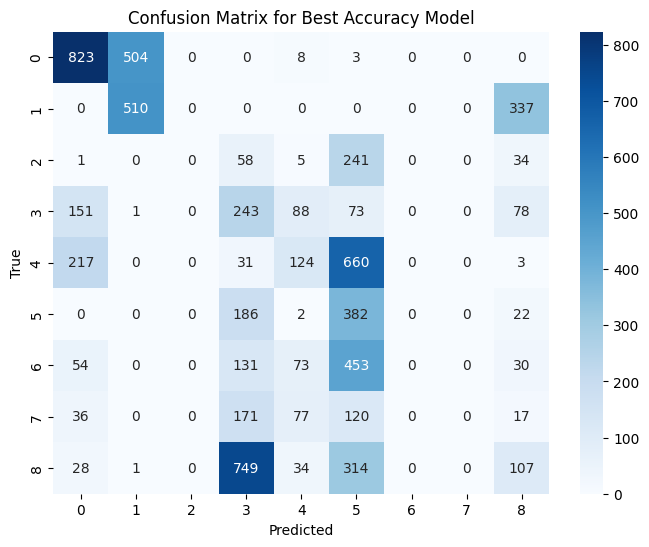

<ipython-input-50-5e4f8a73627b>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loss.load_state_dict(torch.load("best_model_loss.pth"))
/usr/local/lib/python3.10/dis

Classification Report for Best Loss Model:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1338
           1       0.50      0.60      0.55       847
           2       0.00      0.00      0.00       339
           3       0.15      0.38      0.22       634
           4       0.30      0.12      0.17      1035
           5       0.17      0.65      0.27       592
           6       0.00      0.00      0.00       741
           7       0.00      0.00      0.00       421
           8       0.17      0.09      0.11      1233

    accuracy                           0.30      7180
   macro avg       0.21      0.27      0.22      7180
weighted avg       0.28      0.30      0.27      7180



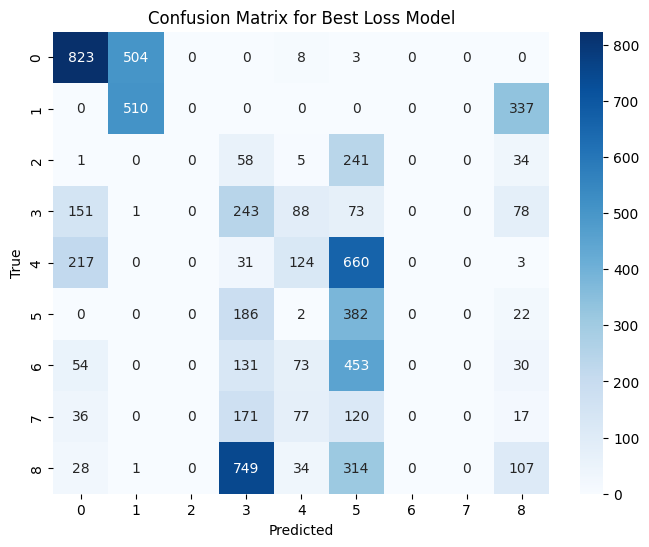

In [50]:
# Create DataLoader for testing
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(9), yticklabels=range(9))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Load the best model based on validation accuracy
model_acc = MLPModel().to(device)
model_acc.load_state_dict(torch.load("best_model_acc.pth"))
model_acc.eval()

# Evaluate the best accuracy model
y_true_acc, y_pred_acc = evaluate_model(model_acc, test_loader)
print("Classification Report for Best Accuracy Model:")
print(classification_report(y_true_acc, y_pred_acc))
plot_confusion_matrix(y_true_acc, y_pred_acc, "Confusion Matrix for Best Accuracy Model")

# Load the best model based on validation loss
model_loss = MLPModel().to(device)
model_loss.load_state_dict(torch.load("best_model_loss.pth"))
model_loss.eval()

# Evaluate the best loss model
y_true_loss, y_pred_loss = evaluate_model(model_loss, test_loader)
print("Classification Report for Best Loss Model:")
print(classification_report(y_true_loss, y_pred_loss))
plot_confusion_matrix(y_true_loss, y_pred_loss, "Confusion Matrix for Best Loss Model")